<a href="https://colab.research.google.com/github/arkapriyathecoderinprogress/BrainTumorDetectionVGG16/blob/main/BrainTumorDetectionVGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras==2.12.0

In [ ]:
!pip install tensorflow==2.12.0

In [3]:
# Import necessary libraries
from google.colab import files
import tensorflow as tf
from zipfile import ZipFile
import os
import cv2
from tqdm.notebook import tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model
from keras.applications import vgg16
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [6]:
# Authenticate and download dataset from Kaggle
uploaded = files.upload()

# Print uploaded file details
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

# Move kaggle.json into the folder where the API expects to find it
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle (10).json to kaggle (10).json
User uploaded file "kaggle (10).json" with length 71 bytes
mv: cannot stat 'kaggle.json': No such file or directory


In [8]:
# Download the dataset from Kaggle
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
# Extract dataset
file_name = "/content/brain-mri-images-for-brain-tumor-detection.zip"
with ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall()
print('Dataset extraction complete')

Dataset extraction complete


In [10]:
# Prepare data lists
X = []  # List to hold image data
y = []  # List to hold labels

# Load tumor images
os.chdir('/content/yes')
for i in tqdm(os.listdir()):
    img = cv2.imread(i)
    img = cv2.resize(img, (224, 224))  # Resize to VGG16 input size
    X.append(img)
    y.append('Y')  # 'Y' for tumor presence

# Load non-tumor images
os.chdir('/content/no')
for i in tqdm(os.listdir()):
    img = cv2.imread(i)
    img = cv2.resize(img, (224, 224))
    X.append(img)
    y.append('N')  # 'N' for no tumor

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

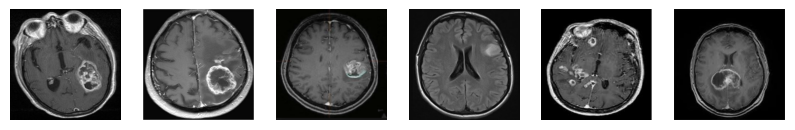

In [11]:
# Display a sample of the images
%matplotlib inline
plt.figure(figsize=(10, 10))
for i in range(6):
    plt.subplot(1, 6, i + 1)
    plt.imshow(X[i])
    plt.axis('off')
plt.show()

In [12]:
# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [13]:
# Print shapes of the data arrays
print("Shape of an image in X_train: ", X_train[0].shape)
print("Shape of an image in X_test: ", X_test[0].shape)

Shape of an image in X_train:  (224, 224, 3)
Shape of an image in X_test:  (224, 224, 3)


In [14]:
# Encode labels as integers
le = preprocessing.LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [15]:
# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train_encoded, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test_encoded, num_classes=2)

In [17]:
# Convert data to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (169, 224, 224, 3)
X_test Shape:  (84, 224, 224, 3)
y_train Shape:  (169, 2)
y_test Shape:  (84, 2)


In [19]:
# Load pre-trained VGG16 model
img_rows, img_cols = 224, 224
vgg = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))

# Fine-tune the model by unfreezing some layers
for layer in vgg.layers[:15]:
    layer.trainable = False
for layer in vgg.layers[15:]:
    layer.trainable = True

# Let's print our layers
for (i,layer) in enumerate(vgg.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D True
16 Conv2D True
17 Conv2D True
18 MaxPooling2D True


In [20]:
# Define a function to add a custom head to the pre-trained model
def lw(bottom_model, num_classes):
    """Creates the top or head of the model
       that will be placed ontop of the bottom layers."""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)  # Add dropout for regularization
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)  # Add dropout for regularization
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(num_classes, activation='softmax')(top_model)
    return top_model

In [21]:
# Add the custom head to the pre-trained VGG16 model
num_classes = 2
FC_Head = lw(vgg, num_classes)
model = Model(inputs=vgg.input, outputs=FC_Head)

# Print the model summary
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [22]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,          # Randomly rotate images by 20 degrees
    width_shift_range=0.2,      # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.2,     # Randomly shift images vertically by 20% of the height
    shear_range=0.2,            # Apply shearing transformations
    zoom_range=0.2,             # Randomly zoom into images
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill newly created pixels with the nearest available pixel
)

# Callbacks for early stopping, learning rate reduction, and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Train the model with data augmentation
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

Epoch 1/20
6/6 [==============================] - 208s 39s/step - loss: 1.4863 - accuracy: 0.5325 - val_loss: 0.7110 - val_accuracy: 0.6071 - lr: 1.0000e-04
Epoch 2/20
6/6 [==============================] - 200s 35s/step - loss: 0.6609 - accuracy: 0.6095 - val_loss: 0.6306 - val_accuracy: 0.6071 - lr: 1.0000e-04
Epoch 3/20
6/6 [==============================] - 201s 36s/step - loss: 0.6401 - accuracy: 0.6331 - val_loss: 0.6160 - val_accuracy: 0.6071 - lr: 1.0000e-04
Epoch 4/20
6/6 [==============================] - 199s 35s/step - loss: 0.5868 - accuracy: 0.6213 - val_loss: 0.5815 - val_accuracy: 0.6071 - lr: 1.0000e-04
Epoch 5/20
6/6 [==============================] - 199s 35s/step - loss: 0.5668 - accuracy: 0.6391 - val_loss: 0.5348 - val_accuracy: 0.6071 - lr: 1.0000e-04
Epoch 6/20
6/6 [==============================] - 168s 29s/step - loss: 0.4965 - accuracy: 0.6391 - val_loss: 0.5038 - val_accuracy: 0.6310 - lr: 1.0000e-04
Epoch 7/20
6/6 [==============================] - 198s 35s

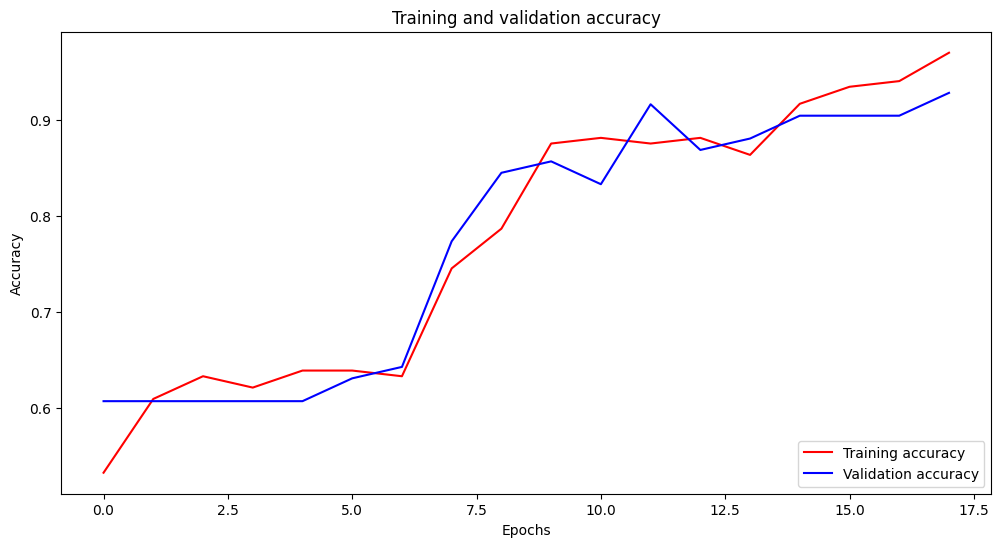

<Figure size 640x480 with 0 Axes>

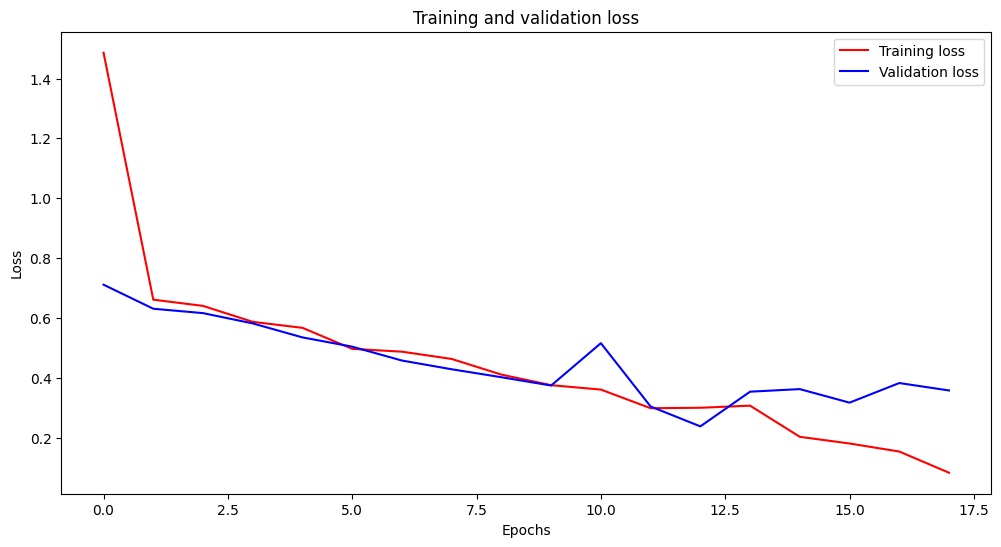

In [24]:
# Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 6))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.figure()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [25]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

3/3 [==============================] - 47s 14s/step - loss: 0.2374 - accuracy: 0.8690
Test Loss: 0.2373988777399063
Test Accuracy: 0.8690476417541504


In [26]:
# Classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=['No Tumor', 'Tumor']))

3/3 [==============================] - 66s 16s/step
Classification Report:
               precision    recall  f1-score   support

    No Tumor       0.79      0.91      0.85        33
       Tumor       0.93      0.84      0.89        51

    accuracy                           0.87        84
   macro avg       0.86      0.88      0.87        84
weighted avg       0.88      0.87      0.87        84



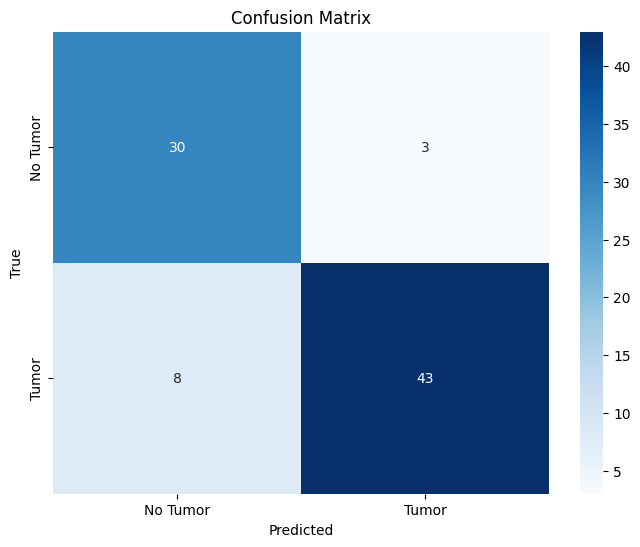

In [27]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()